# Weight Initialization in Deep Neural Networks

## Educational Demonstration

This comprehensive notebook demonstrates how different weight initialization strategies affect the training of deep neural networks through hands-on experimentation and visualization.

**Learning objectives:**
- Understand why proper weight initialization is critical for deep learning
- Observe vanishing and exploding gradient problems in action
- Compare modern initialization strategies (Xavier/Glorot and He/Kaiming)
- Analyze gradient flow through deep networks

## Initialization Strategies Compared

1. **Zero Initialization (W=0)** - Why this fails (symmetry breaking problem)
2. **Low Std Gaussian (std=0.01)** - Vanishing gradients
3. **High Std Gaussian (std=1.0)** - Exploding gradients
4. **Xavier/Glorot** - Balanced initialization for sigmoid/tanh
5. **He/Kaiming** - Optimized for ReLU activations

**Architecture:** Deep MLP with 6 hidden layers trained on MNIST to amplify initialization effects.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
pl.seed_everything(42)

Seed set to 42


42

## 1. Define the Deep MLP Architecture

We'll create a **deep** network (6 hidden layers) to clearly demonstrate vanishing/exploding gradients.

Architecture: 784 → 512 → 256 → 128 → 64 → 32 → 16 → 10

In [2]:
class DeepMLP(pl.LightningModule):
    def __init__(self, init_method='xavier', init_std=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        # Use manual optimization to control backward pass
        self.automatic_optimization = False

        # Define layers
        self.layers = nn.ModuleList([
            nn.Linear(784, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 10)
        ])

        # Initialize weights
        self.init_method = init_method
        self._initialize_weights(init_std)

        # Storage for tracking
        self.gradient_history = {i: [] for i in range(len(self.layers))}
        self.weight_history = {i: [] for i in range(len(self.layers))}
        self.activation_history = {i: [] for i in range(len(self.layers))}
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

        # Storage for gradients and activations per batch
        self.current_epoch_gradients = {i: [] for i in range(len(self.layers))}
        self.current_epoch_activations = {i: [] for i in range(len(self.layers))}

    def _initialize_weights(self, std):
        """Initialize weights based on the specified method"""
        for layer in self.layers:
            if self.init_method == 'zeros':
                nn.init.zeros_(layer.weight)
                nn.init.zeros_(layer.bias)

            elif self.init_method == 'low_gaussian':
                nn.init.normal_(layer.weight, mean=0.0, std=std)
                nn.init.zeros_(layer.bias)

            elif self.init_method == 'high_gaussian':
                nn.init.normal_(layer.weight, mean=0.0, std=std)
                nn.init.zeros_(layer.bias)

            elif self.init_method == 'xavier':
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

            elif self.init_method == 'he':
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten

        # Store activations for analysis (only during training)
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = F.relu(x)
            if self.training:
                # Store activation statistics
                with torch.no_grad():
                    act_mean = x.mean().item()
                    act_std = x.std().item()
                    self.current_epoch_activations[i].append({'mean': act_mean, 'std': act_std})

        # Last layer (no activation)
        x = self.layers[-1](x)

        return x

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Manual backward
        opt.zero_grad()
        self.manual_backward(loss)
        
        # NOW capture gradients - they definitely exist here!
        for i, layer in enumerate(self.layers):
            if layer.weight.grad is not None:
                grad_norm = layer.weight.grad.norm().item()
                self.current_epoch_gradients[i].append(grad_norm)
        
        # Optimizer step
        opt.step()

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def on_train_epoch_start(self):
        """Reset storage at the start of each epoch"""
        self.current_epoch_gradients = {i: [] for i in range(len(self.layers))}
        self.current_epoch_activations = {i: [] for i in range(len(self.layers))}

    def on_train_epoch_end(self):
        """Aggregate and store gradients/activations at the end of each epoch"""
        # Store gradient statistics
        for i in range(len(self.layers)):
            if len(self.current_epoch_gradients[i]) > 0:
                avg_grad = np.mean(self.current_epoch_gradients[i])
                self.gradient_history[i].append(avg_grad)
                print(f"DEBUG: Layer {i} avg gradient: {avg_grad:.6e}")  # DEBUG
            else:
                self.gradient_history[i].append(0.0)
                print(f"DEBUG: Layer {i} NO GRADIENTS")  # DEBUG
        
        # Store weight snapshots
        for i, layer in enumerate(self.layers):
            self.weight_history[i].append(layer.weight.data.cpu().numpy().flatten().copy())
        
        # Store activation statistics
        for i in range(len(self.layers) - 1):  # Exclude output layer
            if len(self.current_epoch_activations[i]) > 0:
                avg_act_mean = np.mean([a['mean'] for a in self.current_epoch_activations[i]])
                avg_act_std = np.mean([a['std'] for a in self.current_epoch_activations[i]])
                self.activation_history[i].append({'mean': avg_act_mean, 'std': avg_act_std})

print("✓ Model class defined")

✓ Model class defined


## 2. Setup Data Loaders

In [3]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)

print(f"✓ Data loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

✓ Data loaded: 60000 training samples, 10000 validation samples


## 3. Custom Callback for Tracking Metrics

In [4]:
class MetricsCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        # Get metrics from trainer
        metrics = trainer.callback_metrics
        
        if 'train_loss' in metrics:
            pl_module.train_losses.append(metrics['train_loss'].item())
        if 'train_acc' in metrics:
            pl_module.train_accs.append(metrics['train_acc'].item())
    
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        
        if 'val_loss' in metrics:
            pl_module.val_losses.append(metrics['val_loss'].item())
        if 'val_acc' in metrics:
            pl_module.val_accs.append(metrics['val_acc'].item())

print("✓ Callback defined")

✓ Callback defined


## 4. Train Models with Different Initializations

This will take a few minutes. We'll train each model for 20 epochs.

## 3b. Simple Gradient Test (Debug)

In [5]:
# Define initialization strategies
init_configs = [
    {'name': 'Zero (W=0)', 'method': 'zeros', 'std': 0.0},
    {'name': 'Low Gaussian (std=0.01)', 'method': 'low_gaussian', 'std': 0.0001},
    {'name': 'High Gaussian (std=1.0)', 'method': 'high_gaussian', 'std': 10.0},
    {'name': 'Xavier/Glorot', 'method': 'xavier', 'std': 0.0},
    {'name': 'He/Kaiming', 'method': 'he', 'std': 0.0},
]

# Store trained models
models = {}
results = {}

MAX_EPOCHS = 20

print("Starting training...\n")

for config in init_configs:
    print(f"Training with {config['name']}...")
    
    # Create model
    model = DeepMLP(init_method=config['method'], init_std=config['std'])
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        callbacks=[MetricsCallback()],
        enable_progress_bar=True,
        enable_model_summary=False,
        logger=False,
        accelerator='auto'
    )
    
    # Train
    trainer.fit(model, train_loader, val_loader)
    
    # Store
    models[config['name']] = model
    results[config['name']] = {
        'train_losses': model.train_losses,
        'val_losses': model.val_losses,
        'train_accs': model.train_accs,
        'val_accs': model.val_accs,
        'gradient_history': model.gradient_history,
        'weight_history': model.weight_history,
    }
    
    print(f"  Final val_acc: {model.val_accs[-1]:.4f}\n")

print("✓ All models trained!")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training...

Training with Zero (W=0)...


You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: 100%|██████████| 469/469 [00:03<00:00, 145.55it/s, train_loss=2.300, train_acc=0.167, val_loss=2.300, val_acc=0.113]DEBUG: Layer 0 avg gradient: 0.000000e+00
DEBUG: Layer 1 avg gradient: 0.000000e+00
DEBUG: Layer 2 avg gradient: 0.000000e+00
DEBUG: Layer 3 avg gradient: 0.000000e+00
DEBUG: Layer 4 avg gradient: 0.000000e+00
DEBUG: Layer 5 avg gradient: 0.000000e+00
DEBUG: Layer 6 avg gradient: 0.000000e+00
Epoch 1: 100%|██████████| 469/469 [00:03<00:00, 131.96it/s, train_loss=2.310, train_acc=0.104, val_loss=2.300, val_acc=0.113] DEBUG: Layer 0 avg gradient: 0.000000e+00
DEBUG: Layer 1 avg gradient: 0.000000e+00
DEBUG: Layer 2 avg gradient: 0.000000e+00
DEBUG: Layer 3 avg gradient: 0.000000e+00
DEBUG: Layer 4 avg gradient: 0.000000e+00
DEBUG: Layer 5 avg gradient: 0.000000e+00
DEBUG: Layer 6 avg gradient: 0.000000e+00
Epoch 2: 100%|██████████| 469/469 [00:03<00:00, 148.97it/s, train_loss=2.300, train_acc=0.0938, val_loss=2.300, val_acc=0.113]DEBUG: Layer 0 avg gradient: 0.0000

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:03<00:00, 137.88it/s, train_loss=2.300, train_acc=0.0833, val_loss=2.300, val_acc=0.113]
  Final val_acc: 0.1135

Training with Low Gaussian (std=0.01)...


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: 100%|██████████| 469/469 [00:03<00:00, 134.94it/s, train_loss=1.100, train_acc=0.635, val_loss=1.050, val_acc=0.617]DEBUG: Layer 0 avg gradient: 7.535791e-02
DEBUG: Layer 1 avg gradient: 9.860409e-02
DEBUG: Layer 2 avg gradient: 2.157087e-01
DEBUG: Layer 3 avg gradient: 3.606708e-01
DEBUG: Layer 4 avg gradient: 9.229382e-01
DEBUG: Layer 5 avg gradient: 1.599591e+00
DEBUG: Layer 6 avg gradient: 3.820227e+00
Epoch 1: 100%|██████████| 469/469 [00:03<00:00, 133.71it/s, train_loss=0.817, train_acc=0.667, val_loss=0.639, val_acc=0.787]DEBUG: Layer 0 avg gradient: 4.213615e-01
DEBUG: Layer 1 avg gradient: 3.435814e-01
DEBUG: Layer 2 avg gradient: 6.600534e-01
DEBUG: Layer 3 avg gradient: 1.241297e+00
DEBUG: Layer 4 avg gradient: 3.129588e+00
DEBUG: Layer 5 avg gradient: 6.102541e+00
DEBUG: Layer 6 avg gradient: 1.356741e+01
Epoch 2: 100%|██████████| 469/469 [00:03<00:00, 130.93it/s, train_loss=0.520, train_acc=0.823, val_loss=0.475, val_acc=0.875]DEBUG: Layer 0 avg gradient: 5.206395

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:03<00:00, 123.16it/s, train_loss=0.00159, train_acc=1.000, val_loss=0.179, val_acc=0.971]
  Final val_acc: 0.9709

Training with High Gaussian (std=1.0)...


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: 100%|██████████| 469/469 [00:03<00:00, 128.94it/s, train_loss=1.71e+12, train_acc=0.219, val_loss=1.68e+12, val_acc=0.217]DEBUG: Layer 0 avg gradient: 2.272057e+11
DEBUG: Layer 1 avg gradient: 2.690757e+11
DEBUG: Layer 2 avg gradient: 3.460489e+11
DEBUG: Layer 3 avg gradient: 4.236915e+11
DEBUG: Layer 4 avg gradient: 3.568306e+11
DEBUG: Layer 5 avg gradient: 4.036072e+11
DEBUG: Layer 6 avg gradient: 2.261977e+11
Epoch 1: 100%|██████████| 469/469 [00:03<00:00, 130.23it/s, train_loss=1.28e+11, train_acc=0.188, val_loss=1.81e+11, val_acc=0.172]DEBUG: Layer 0 avg gradient: 5.690488e+10
DEBUG: Layer 1 avg gradient: 6.025483e+10
DEBUG: Layer 2 avg gradient: 6.840573e+10
DEBUG: Layer 3 avg gradient: 8.433582e+10
DEBUG: Layer 4 avg gradient: 9.619906e+10
DEBUG: Layer 5 avg gradient: 1.152772e+11
DEBUG: Layer 6 avg gradient: 2.091426e+10
Epoch 2: 100%|██████████| 469/469 [00:03<00:00, 140.49it/s, train_loss=2.12e+10, train_acc=0.156, val_loss=4.54e+10, val_acc=0.133] DEBUG: Layer 0 avg

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:03<00:00, 132.08it/s, train_loss=2.280, train_acc=0.0938, val_loss=4.37e+8, val_acc=0.115]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


  Final val_acc: 0.1147

Training with Xavier/Glorot...
Epoch 0: 100%|██████████| 469/469 [00:03<00:00, 145.87it/s, train_loss=0.0312, train_acc=0.990, val_loss=0.143, val_acc=0.956]DEBUG: Layer 0 avg gradient: 7.161777e-01
DEBUG: Layer 1 avg gradient: 7.370085e-01
DEBUG: Layer 2 avg gradient: 9.034378e-01
DEBUG: Layer 3 avg gradient: 1.158645e+00
DEBUG: Layer 4 avg gradient: 1.326506e+00
DEBUG: Layer 5 avg gradient: 1.336822e+00
DEBUG: Layer 6 avg gradient: 8.584170e-01
Epoch 1: 100%|██████████| 469/469 [00:03<00:00, 134.84it/s, train_loss=0.115, train_acc=0.969, val_loss=0.115, val_acc=0.964] DEBUG: Layer 0 avg gradient: 5.155638e-01
DEBUG: Layer 1 avg gradient: 4.111632e-01
DEBUG: Layer 2 avg gradient: 4.204568e-01
DEBUG: Layer 3 avg gradient: 5.552403e-01
DEBUG: Layer 4 avg gradient: 6.995479e-01
DEBUG: Layer 5 avg gradient: 7.507025e-01
DEBUG: Layer 6 avg gradient: 5.310317e-01
Epoch 2: 100%|██████████| 469/469 [00:03<00:00, 122.53it/s, train_loss=0.00355, train_acc=1.000, val_los

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:03<00:00, 121.74it/s, train_loss=0.0161, train_acc=1.000, val_loss=0.106, val_acc=0.979]
  Final val_acc: 0.9789

Training with He/Kaiming...


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: 100%|██████████| 469/469 [00:02<00:00, 161.50it/s, train_loss=0.161, train_acc=0.969, val_loss=0.135, val_acc=0.957]DEBUG: Layer 0 avg gradient: 9.262140e-01
DEBUG: Layer 1 avg gradient: 9.005957e-01
DEBUG: Layer 2 avg gradient: 9.744925e-01
DEBUG: Layer 3 avg gradient: 1.029035e+00
DEBUG: Layer 4 avg gradient: 1.111509e+00
DEBUG: Layer 5 avg gradient: 9.546063e-01
DEBUG: Layer 6 avg gradient: 5.795939e-01
Epoch 1: 100%|██████████| 469/469 [00:03<00:00, 129.00it/s, train_loss=0.242, train_acc=0.948, val_loss=0.112, val_acc=0.967] DEBUG: Layer 0 avg gradient: 6.030592e-01
DEBUG: Layer 1 avg gradient: 4.915480e-01
DEBUG: Layer 2 avg gradient: 4.874478e-01
DEBUG: Layer 3 avg gradient: 5.367243e-01
DEBUG: Layer 4 avg gradient: 5.963945e-01
DEBUG: Layer 5 avg gradient: 5.617756e-01
DEBUG: Layer 6 avg gradient: 3.736725e-01
Epoch 2: 100%|██████████| 469/469 [00:03<00:00, 146.61it/s, train_loss=0.0314, train_acc=1.000, val_loss=0.108, val_acc=0.968] DEBUG: Layer 0 avg gradient: 5.341

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:03<00:00, 136.43it/s, train_loss=0.0095, train_acc=1.000, val_loss=0.124, val_acc=0.979]
  Final val_acc: 0.9786

✓ All models trained!


## 5. Visualization: Loss and Accuracy Curves

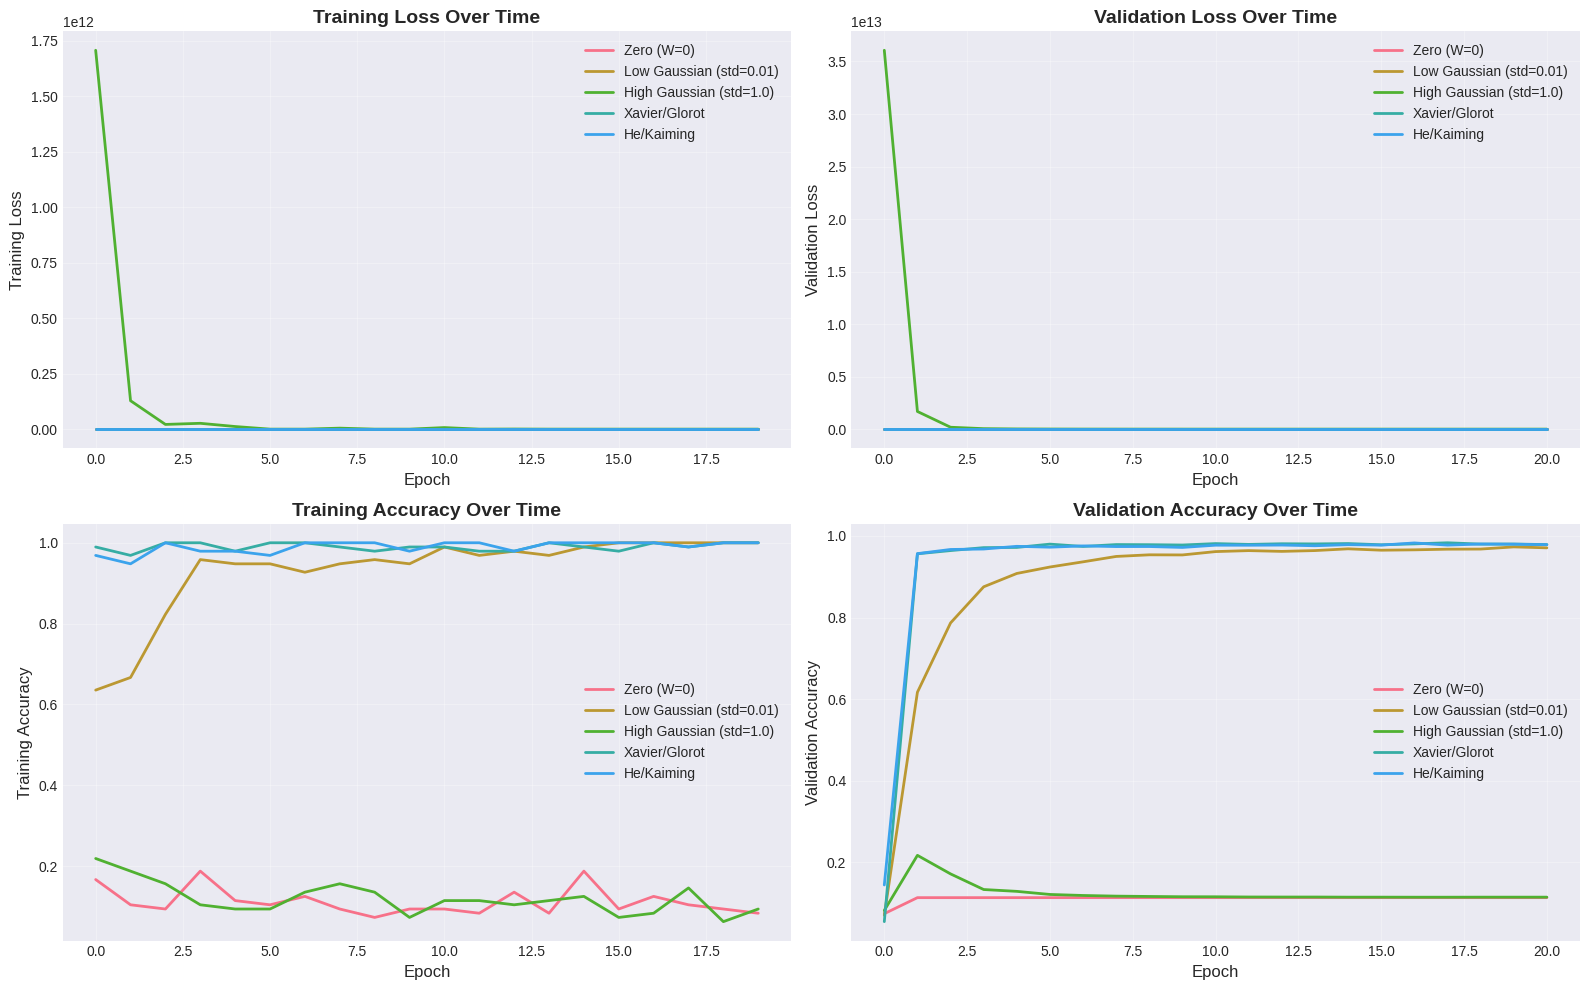


📊 Key Observations:
- Zero initialization: Fails to learn (symmetry problem)
- Low Gaussian: Slow learning (vanishing gradients)
- High Gaussian: Unstable training (exploding gradients)
- Xavier/He: Stable and efficient learning


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training Loss
ax = axes[0, 0]
for name, data in results.items():
    if len(data['train_losses']) > 0:
        ax.plot(data['train_losses'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss
ax = axes[0, 1]
for name, data in results.items():
    if len(data['val_losses']) > 0:
        ax.plot(data['val_losses'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Validation Loss Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Training Accuracy
ax = axes[1, 0]
for name, data in results.items():
    if len(data['train_accs']) > 0:
        ax.plot(data['train_accs'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Accuracy', fontsize=12)
ax.set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Accuracy
ax = axes[1, 1]
for name, data in results.items():
    if len(data['val_accs']) > 0:
        ax.plot(data['val_accs'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Validation Accuracy Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('initialization_loss_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Key Observations:")
print("- Zero initialization: Fails to learn (symmetry problem)")
print("- Low Gaussian: Slow learning (vanishing gradients)")
print("- High Gaussian: Unstable training (exploding gradients)")
print("- Xavier/He: Stable and efficient learning")

## 6. Visualization: Gradient Flow Through Layers

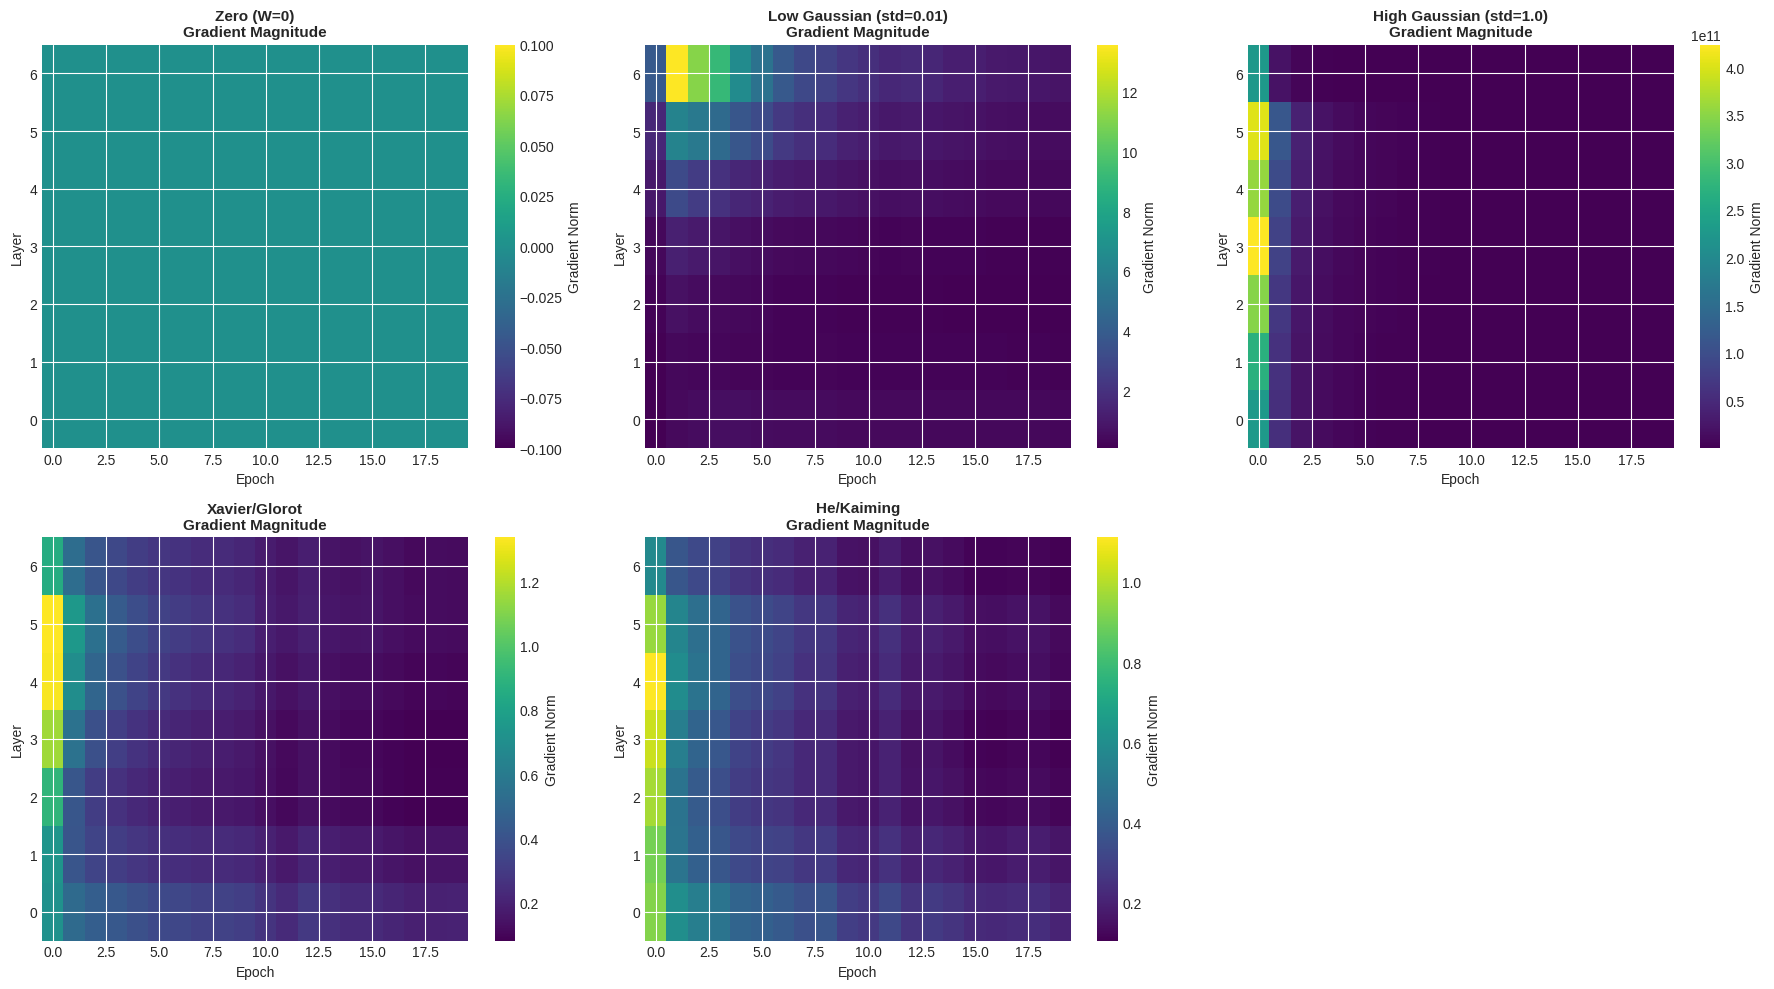


📊 Gradient Flow Insights:
- Darker colors = smaller gradients (vanishing)
- Brighter colors = larger gradients (potentially exploding)
- Zero init: No gradient flow (all layers stuck)
- Low std: Vanishing gradients in early layers
- High std: Unstable, potentially exploding gradients
- Xavier/He: Balanced gradient flow across all layers


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, data) in enumerate(results.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Prepare gradient data for heatmap
    grad_data = []
    for layer_idx in range(len(data['gradient_history'])):
        grad_data.append(data['gradient_history'][layer_idx])
    
    if len(grad_data) > 0 and len(grad_data[0]) > 0:
        grad_array = np.array(grad_data)
        
        # Plot heatmap
        im = ax.imshow(grad_array, aspect='auto', cmap='viridis', 
                       interpolation='nearest', origin='lower')
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Layer', fontsize=10)
        ax.set_title(f'{name}\nGradient Magnitude', fontsize=11, fontweight='bold')
        plt.colorbar(im, ax=ax, label='Gradient Norm')
    else:
        ax.text(0.5, 0.5, 'No gradient data', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(f'{name}\nGradient Magnitude', fontsize=11, fontweight='bold')

# Remove extra subplot
if len(results) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('initialization_gradient_flow.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Gradient Flow Insights:")
print("- Darker colors = smaller gradients (vanishing)")
print("- Brighter colors = larger gradients (potentially exploding)")
print("- Zero init: No gradient flow (all layers stuck)")
print("- Low std: Vanishing gradients in early layers")
print("- High std: Unstable, potentially exploding gradients")
print("- Xavier/He: Balanced gradient flow across all layers")

## 7. Visualization: Weight Distribution Evolution

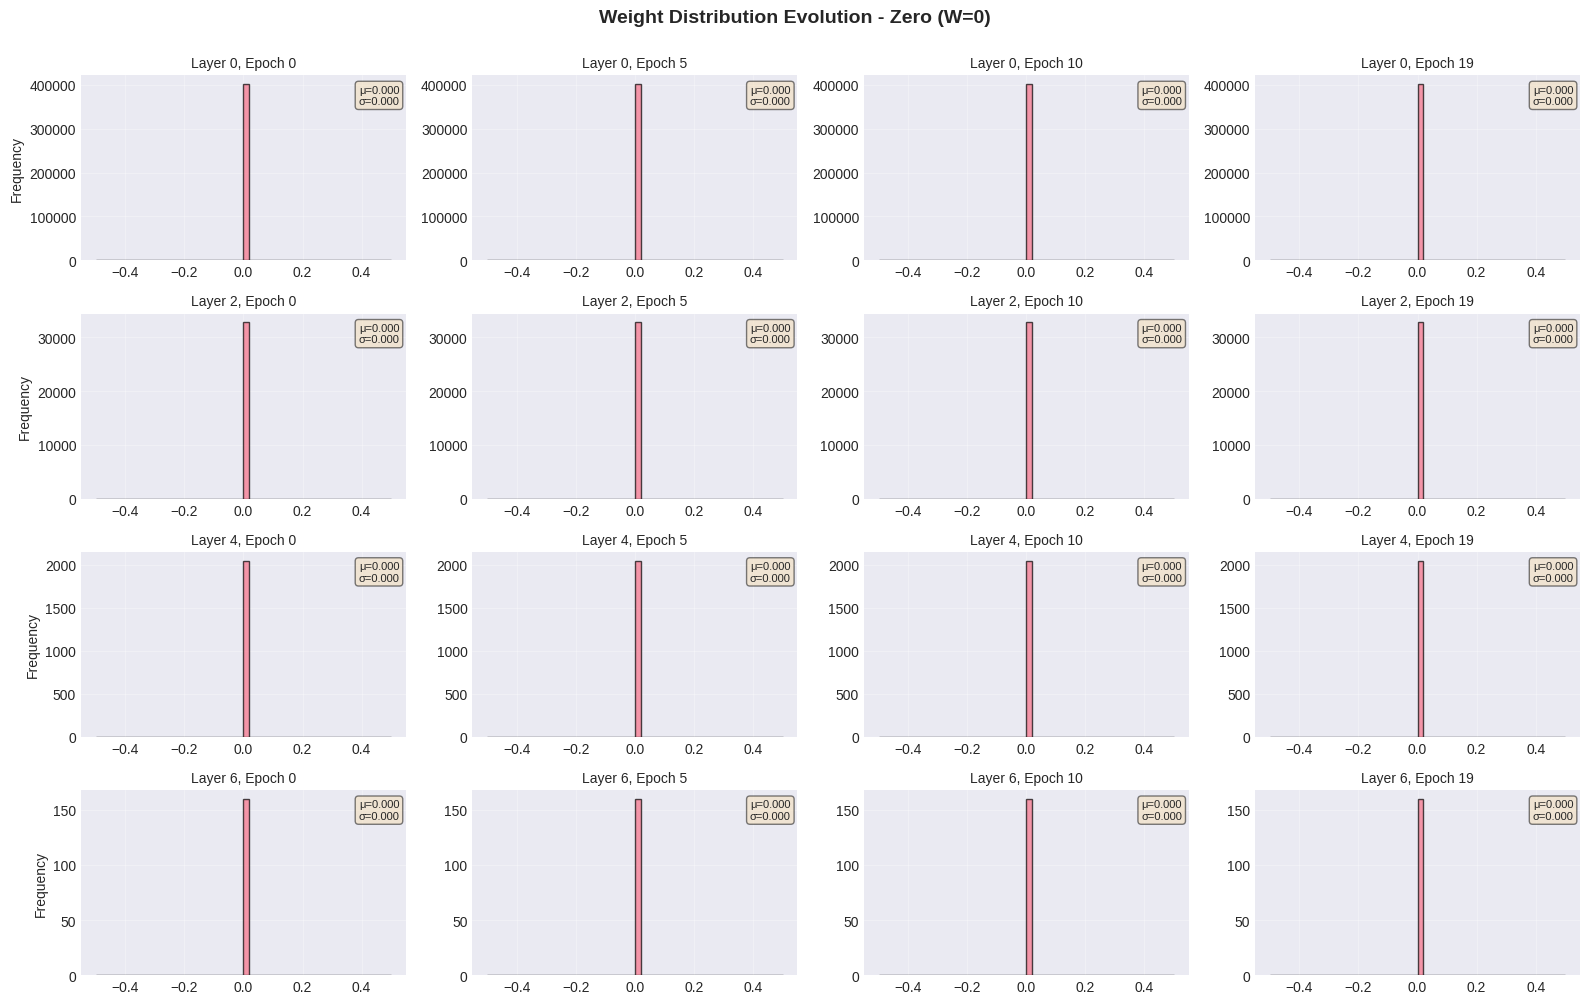

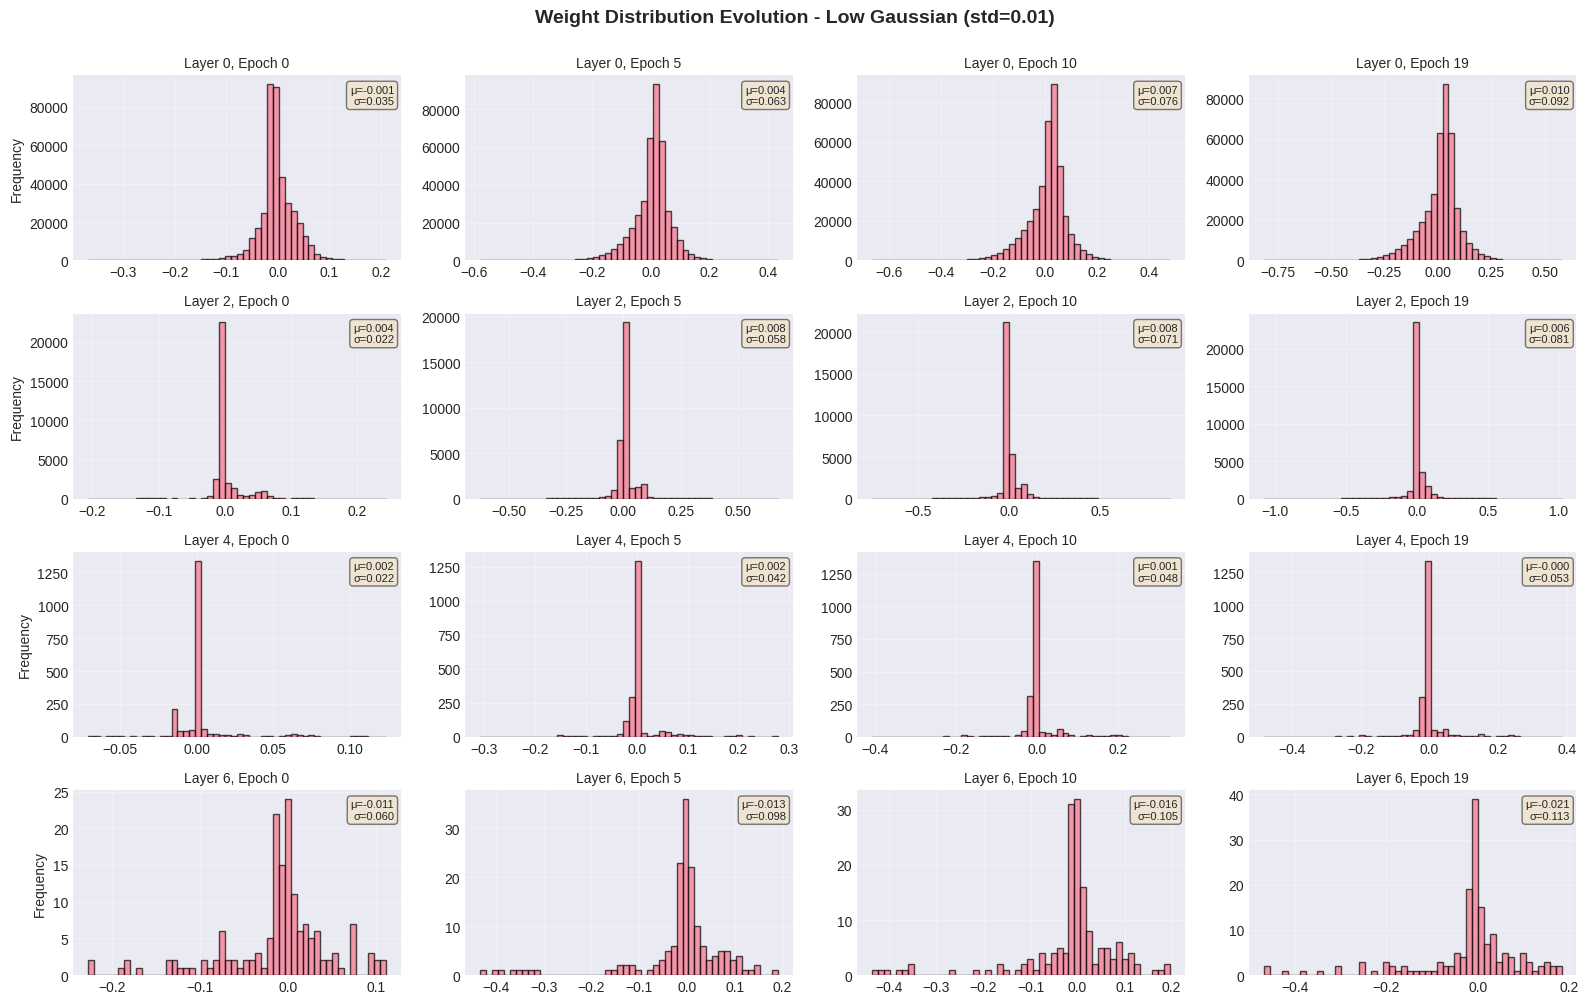

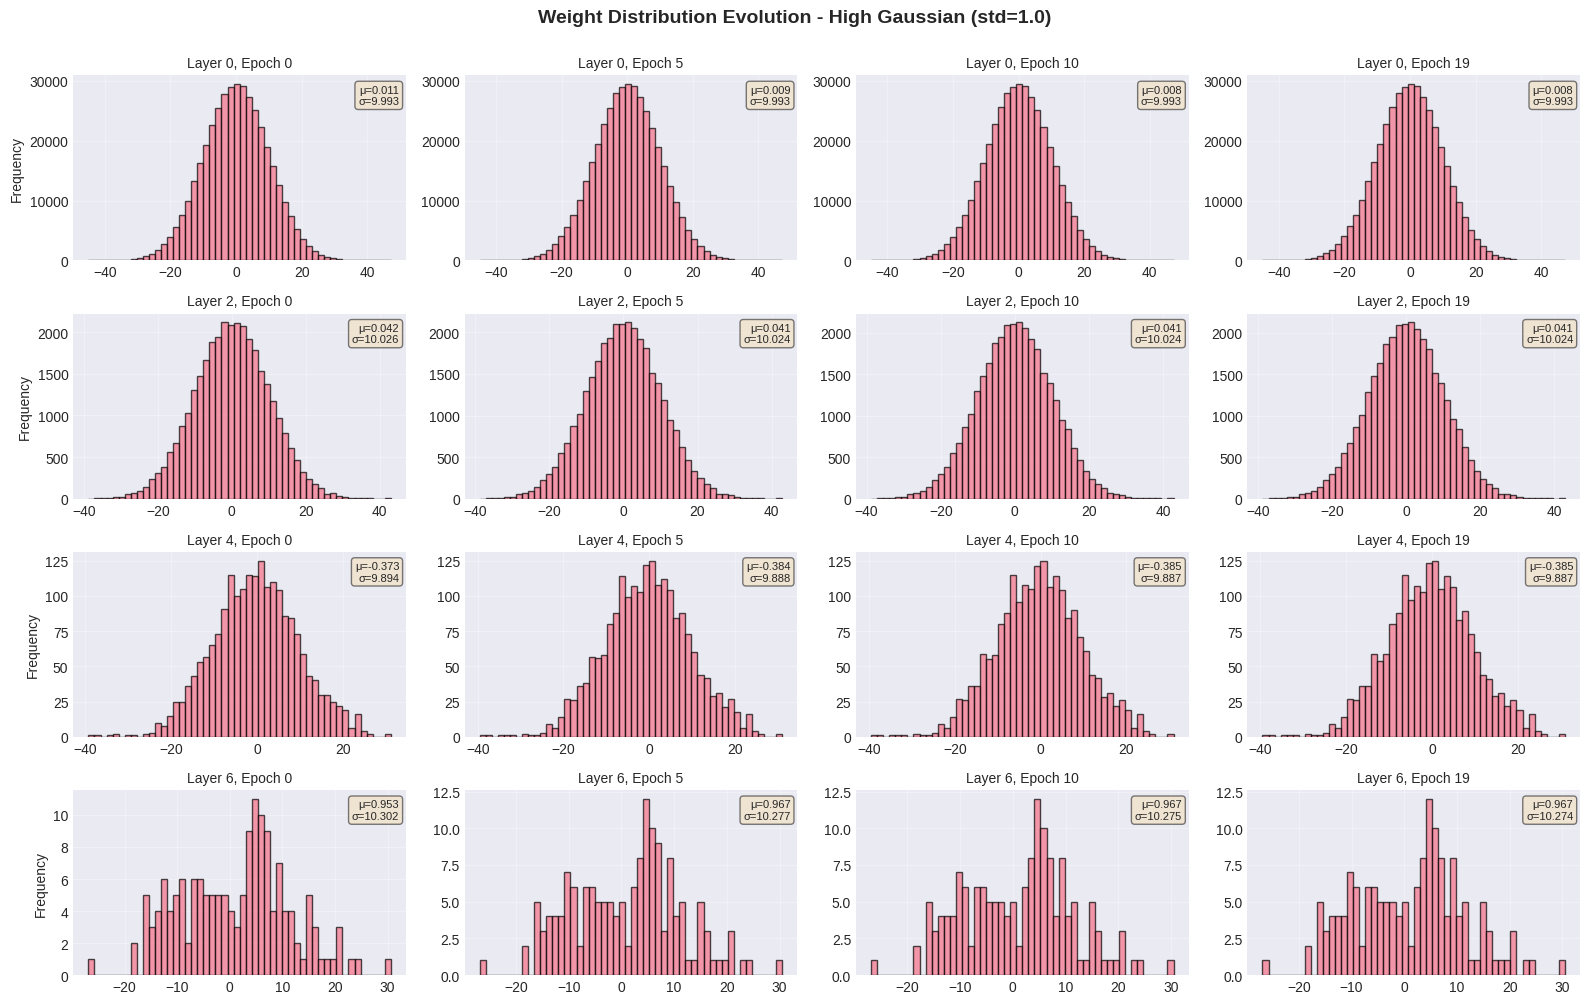

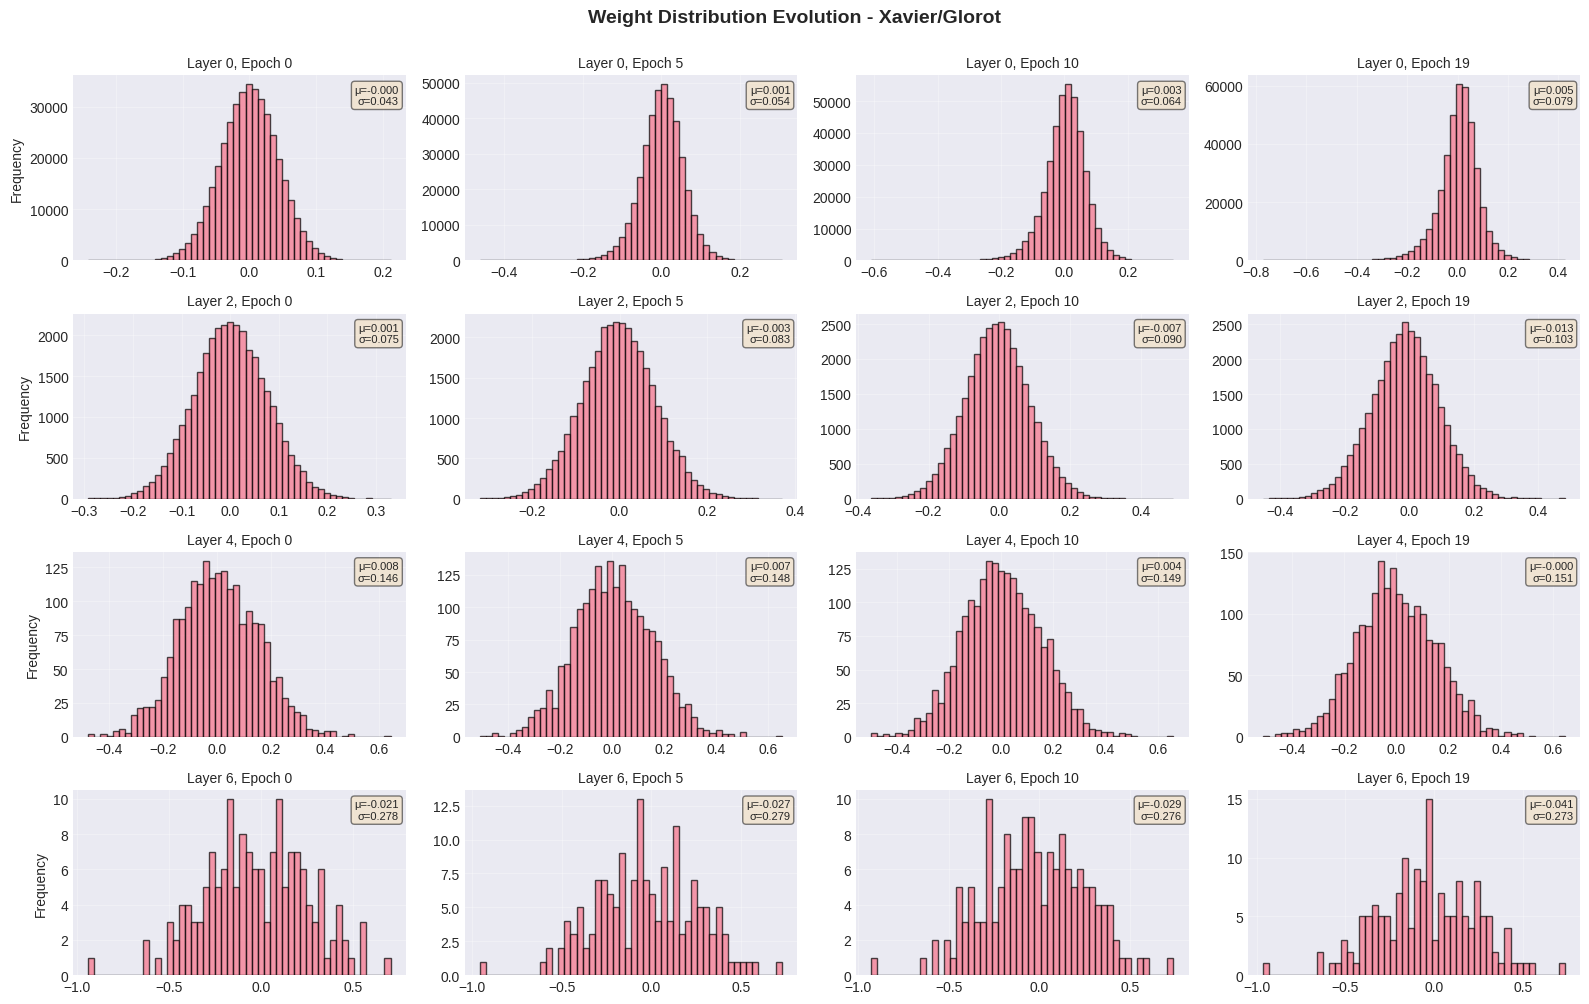

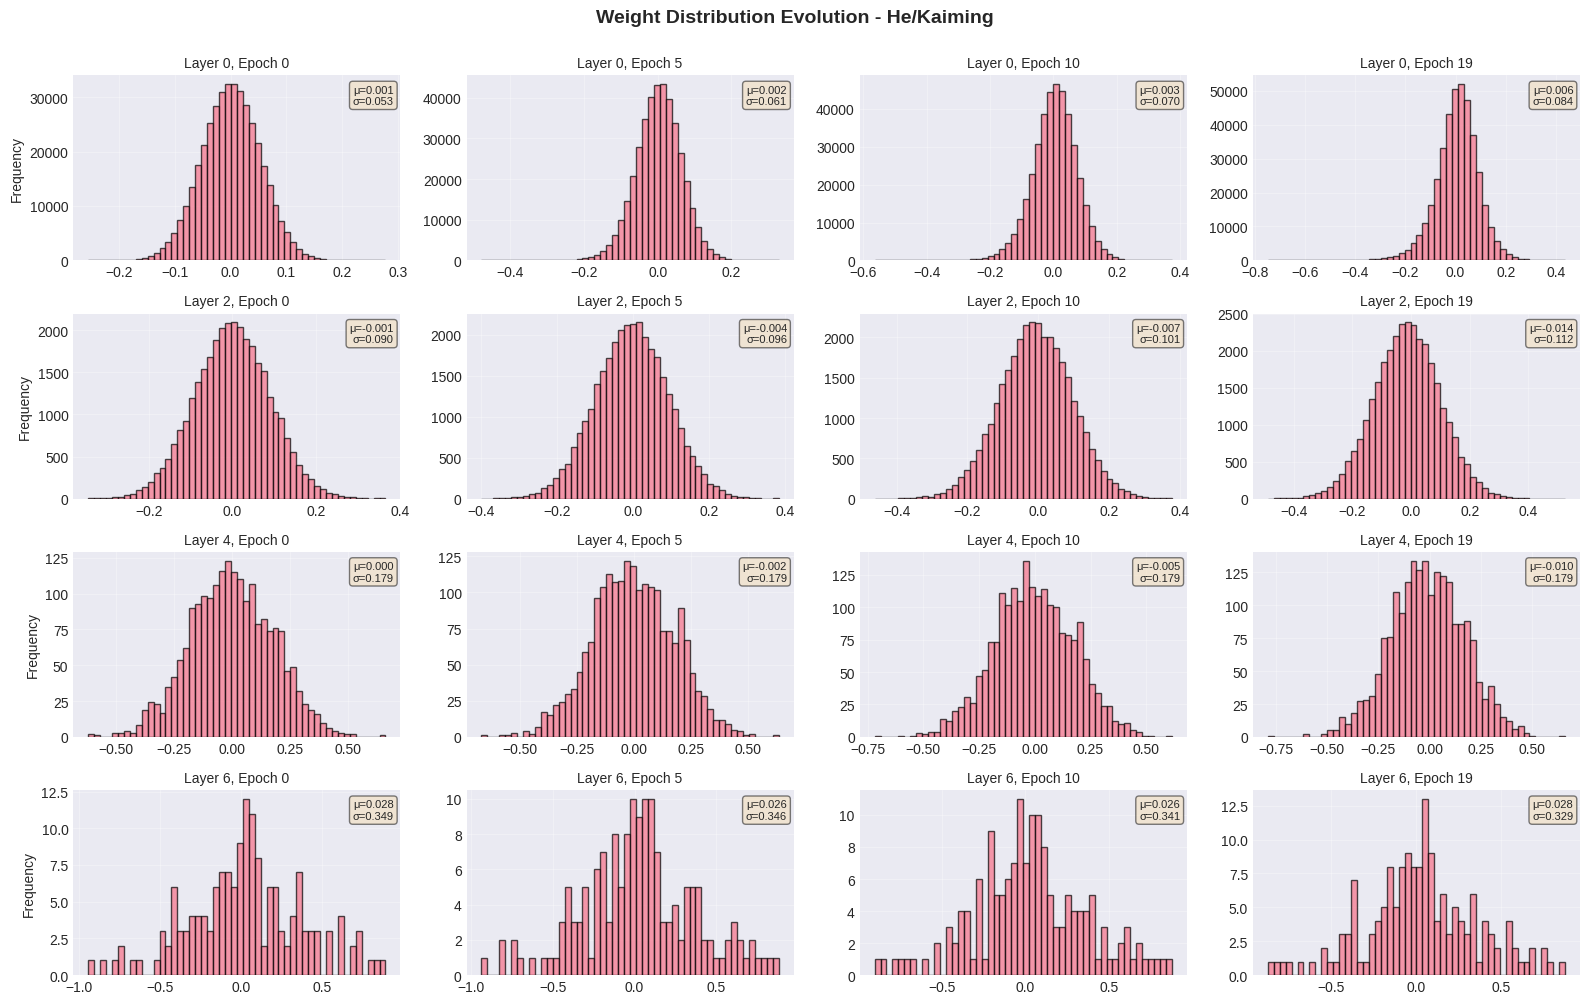

In [8]:
def plot_weight_distributions(model_name, snapshots=[0, 5, 10, 19]):
    """Plot weight distributions at different epochs for a specific model"""
    data = results[model_name]
    weight_hist = data['weight_history']
    
    # Select a few representative layers
    layers_to_plot = [0, 2, 4, 6]  # First, middle, and last layers
    
    fig, axes = plt.subplots(len(layers_to_plot), len(snapshots), 
                            figsize=(16, 10))
    
    for layer_idx, layer in enumerate(layers_to_plot):
        for snap_idx, epoch in enumerate(snapshots):
            ax = axes[layer_idx, snap_idx]
            
            if epoch < len(weight_hist[layer]):
                weights = weight_hist[layer][epoch]
                ax.hist(weights, bins=50, alpha=0.7, edgecolor='black')
                ax.set_title(f'Layer {layer}, Epoch {epoch}', fontsize=10)
                ax.set_ylabel('Frequency' if snap_idx == 0 else '')
                ax.grid(True, alpha=0.3)
                
                # Add statistics
                mean = np.mean(weights)
                std = np.std(weights)
                ax.text(0.98, 0.95, f'μ={mean:.3f}\nσ={std:.3f}',
                       transform=ax.transAxes, ha='right', va='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                       fontsize=8)
    
    plt.suptitle(f'Weight Distribution Evolution - {model_name}', 
                fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(f'weight_dist_{model_name.replace("/", "_").replace(" ", "_")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

# Plot for each initialization method
for model_name in results.keys():
    if len(results[model_name]['weight_history'][0]) > 0:
        plot_weight_distributions(model_name)

## 8. Detailed Gradient Analysis Per Layer

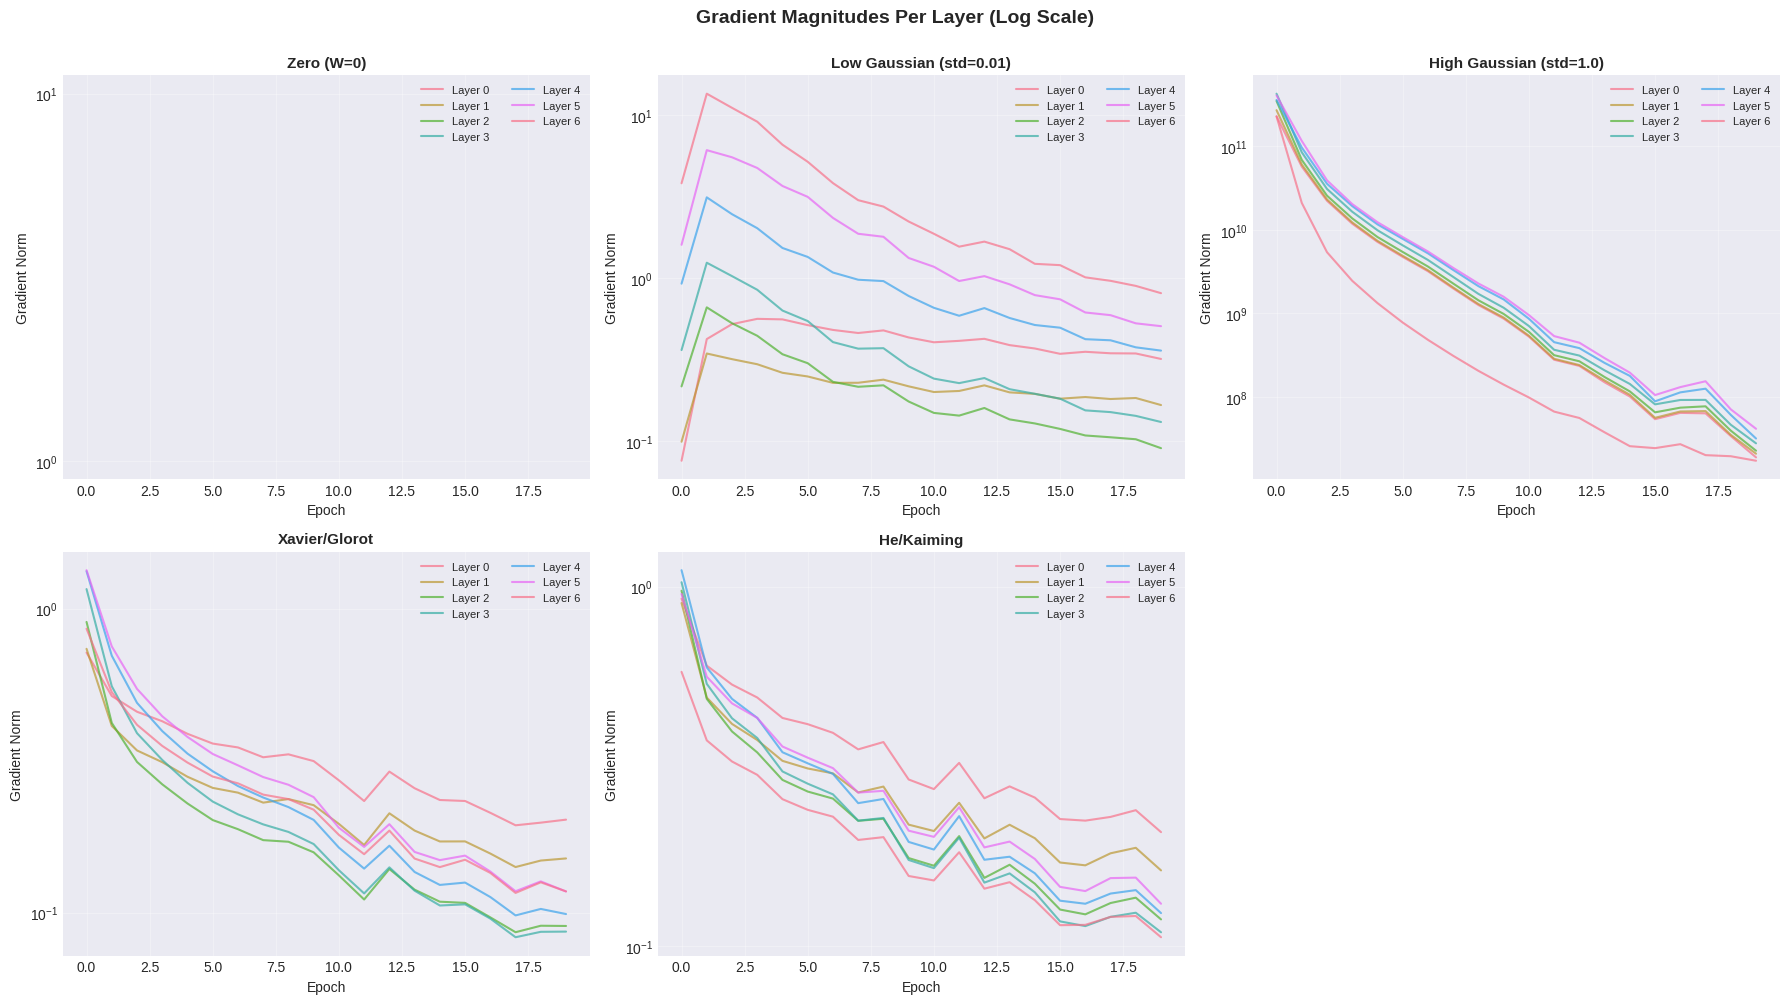


📊 Layer-wise Gradient Analysis:
- Zero init: Gradients remain zero (no learning)
- Low std: Earlier layers have much smaller gradients (vanishing)
- High std: Large variance, potentially unstable
- Xavier/He: More uniform gradient magnitudes across layers


In [9]:
# Plot gradient magnitude for each layer across epochs
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, data) in enumerate(results.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Plot each layer
    for layer_idx in range(len(data['gradient_history'])):
        grads = data['gradient_history'][layer_idx]
        if len(grads) > 0:
            ax.plot(grads, label=f'Layer {layer_idx}', alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Gradient Norm', fontsize=10)
    ax.set_title(f'{name}', fontsize=11, fontweight='bold')
    ax.set_yscale('log')  # Log scale to see differences better
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
if len(results) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('Gradient Magnitudes Per Layer (Log Scale)', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('gradient_per_layer.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Layer-wise Gradient Analysis:")
print("- Zero init: Gradients remain zero (no learning)")
print("- Low std: Earlier layers have much smaller gradients (vanishing)")
print("- High std: Large variance, potentially unstable")
print("- Xavier/He: More uniform gradient magnitudes across layers")

## 9. Animation: Gradient Flow Evolution

In [10]:
def create_gradient_animation(model_name, save_path='gradient_animation.gif'):
    """Create an animated visualization of gradient flow over epochs"""
    data = results[model_name]
    grad_history = data['gradient_history']
    
    # Prepare data
    num_layers = len(grad_history)
    num_epochs = len(grad_history[0]) if grad_history[0] else 0
    
    if num_epochs == 0:
        print(f"No gradient data for {model_name}")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Initialize plot
    bars = ax.bar(range(num_layers), [0] * num_layers)
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_ylabel('Gradient Norm', fontsize=12)
    ax.set_title(f'Gradient Flow - {model_name}\nEpoch 0', 
                fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(max(grad_history[i]) for i in range(num_layers) 
                      if len(grad_history[i]) > 0) * 1.1)
    
    def animate(epoch):
        # Update bar heights
        heights = [grad_history[i][epoch] if epoch < len(grad_history[i]) else 0 
                  for i in range(num_layers)]
        
        for bar, height in zip(bars, heights):
            bar.set_height(height)
        
        ax.set_title(f'Gradient Flow - {model_name}\nEpoch {epoch}', 
                    fontsize=14, fontweight='bold')
        return bars
    
    anim = FuncAnimation(fig, animate, frames=num_epochs, 
                        interval=200, blit=False, repeat=True)
    
    # Save animation
    anim.save(save_path, writer='pillow', fps=5)
    plt.close()
    
    return anim

# Create animations for selected methods
print("Creating gradient flow animations...")
for model_name in ['He/Kaiming', 'Low Gaussian (std=0.01)', 'High Gaussian (std=1.0)']:
    if model_name in results:
        filename = f'gradient_anim_{model_name.replace("/", "_").replace(" ", "_")}.gif'
        create_gradient_animation(model_name, filename)
        print(f"  Saved: {filename}")

print("✓ Animations created!")

Creating gradient flow animations...
  Saved: gradient_anim_He_Kaiming.gif
  Saved: gradient_anim_Low_Gaussian_(std=0.01).gif
  Saved: gradient_anim_High_Gaussian_(std=1.0).gif
✓ Animations created!


## 10. Summary Comparison Table

In [11]:
import pandas as pd

# Create summary table
summary_data = []

for name, data in results.items():
    final_train_acc = data['train_accs'][-1] if len(data['train_accs']) > 0 else 0
    final_val_acc = data['val_accs'][-1] if len(data['val_accs']) > 0 else 0
    final_train_loss = data['train_losses'][-1] if len(data['train_losses']) > 0 else float('inf')
    final_val_loss = data['val_losses'][-1] if len(data['val_losses']) > 0 else float('inf')
    
    # Average gradient magnitude across all layers
    avg_grad = np.mean([np.mean(data['gradient_history'][i]) 
                       for i in range(len(data['gradient_history'])) 
                       if len(data['gradient_history'][i]) > 0])
    
    summary_data.append({
        'Method': name,
        'Final Train Acc': f"{final_train_acc:.4f}",
        'Final Val Acc': f"{final_val_acc:.4f}",
        'Final Train Loss': f"{final_train_loss:.4f}",
        'Final Val Loss': f"{final_val_loss:.4f}",
        'Avg Gradient Norm': f"{avg_grad:.6f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY: Weight Initialization Comparison")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


SUMMARY: Weight Initialization Comparison
                 Method Final Train Acc Final Val Acc Final Train Loss Final Val Loss  Avg Gradient Norm
             Zero (W=0)          0.0833        0.1135           2.3030         2.3010           0.000000
Low Gaussian (std=0.01)          1.0000        0.9709           0.0016         0.1793           1.136808
High Gaussian (std=1.0)          0.0938        0.1147           2.2767 436776736.0000 22856713169.049084
          Xavier/Glorot          1.0000        0.9789           0.0161         0.1057           0.268732
             He/Kaiming          1.0000        0.9786           0.0095         0.1236           0.282467


## 11. Educational Summary

### Why Weight Initialization Matters:

#### 1. **Zero Initialization (W=0)**
- ❌ **Problem**: All neurons in a layer compute the same output
- ❌ **Result**: Symmetry - all neurons receive the same gradient
- ❌ **Outcome**: Network fails to learn, all neurons remain identical

#### 2. **Low Standard Deviation (std=0.01)**
- ⚠️ **Problem**: Weights are too small
- ⚠️ **Result**: Activations and gradients shrink as they propagate backward
- ⚠️ **Outcome**: **Vanishing gradients** - early layers don't learn

#### 3. **High Standard Deviation (std=1.0)**
- ⚠️ **Problem**: Weights are too large
- ⚠️ **Result**: Activations and gradients grow as they propagate
- ⚠️ **Outcome**: **Exploding gradients** - unstable training, NaN values

#### 4. **Xavier/Glorot Initialization**
- ✅ **Goal**: Keep variance of activations constant across layers
- ✅ **Formula**: `Var(W) = 1/n_in` or `Var(W) = 2/(n_in + n_out)`
- ✅ **Best for**: tanh, sigmoid activations

#### 5. **He/Kaiming Initialization**
- ✅ **Goal**: Account for ReLU killing half the neurons
- ✅ **Formula**: `Var(W) = 2/n_in`
- ✅ **Best for**: ReLU, Leaky ReLU activations

### Key Takeaways:
1. Proper initialization prevents vanishing/exploding gradients
2. Different activations need different initialization schemes
3. Modern best practice: **He init for ReLU**, **Xavier for tanh/sigmoid**
4. Deeper networks are more sensitive to initialization
5. Good initialization enables faster convergence and better final performance

## 12. Additional Analysis: Initial Weight Statistics

In [12]:
# Show initial weight statistics for each method
print("\n" + "="*80)
print("Initial Weight Statistics (First Layer)")
print("="*80)

for name, model in models.items():
    first_layer_weights = model.layers[0].weight.data.cpu().numpy().flatten()
    
    print(f"\n{name}:")
    print(f"  Mean: {np.mean(first_layer_weights):.6f}")
    print(f"  Std:  {np.std(first_layer_weights):.6f}")
    print(f"  Min:  {np.min(first_layer_weights):.6f}")
    print(f"  Max:  {np.max(first_layer_weights):.6f}")

print("="*80)


Initial Weight Statistics (First Layer)

Zero (W=0):
  Mean: 0.000000
  Std:  0.000000
  Min:  0.000000
  Max:  0.000000

Low Gaussian (std=0.01):
  Mean: 0.010181
  Std:  0.092494
  Min:  -0.814121
  Max:  0.579337

High Gaussian (std=1.0):
  Mean: 0.008058
  Std:  9.993347
  Min:  -44.956123
  Max:  47.224434

Xavier/Glorot:
  Mean: 0.005301
  Std:  0.078607
  Min:  -0.772949
  Max:  0.425746

He/Kaiming:
  Mean: 0.005684
  Std:  0.084109
  Min:  -0.748636
  Max:  0.436720


## 13. Visualization: Side-by-Side Final Comparison

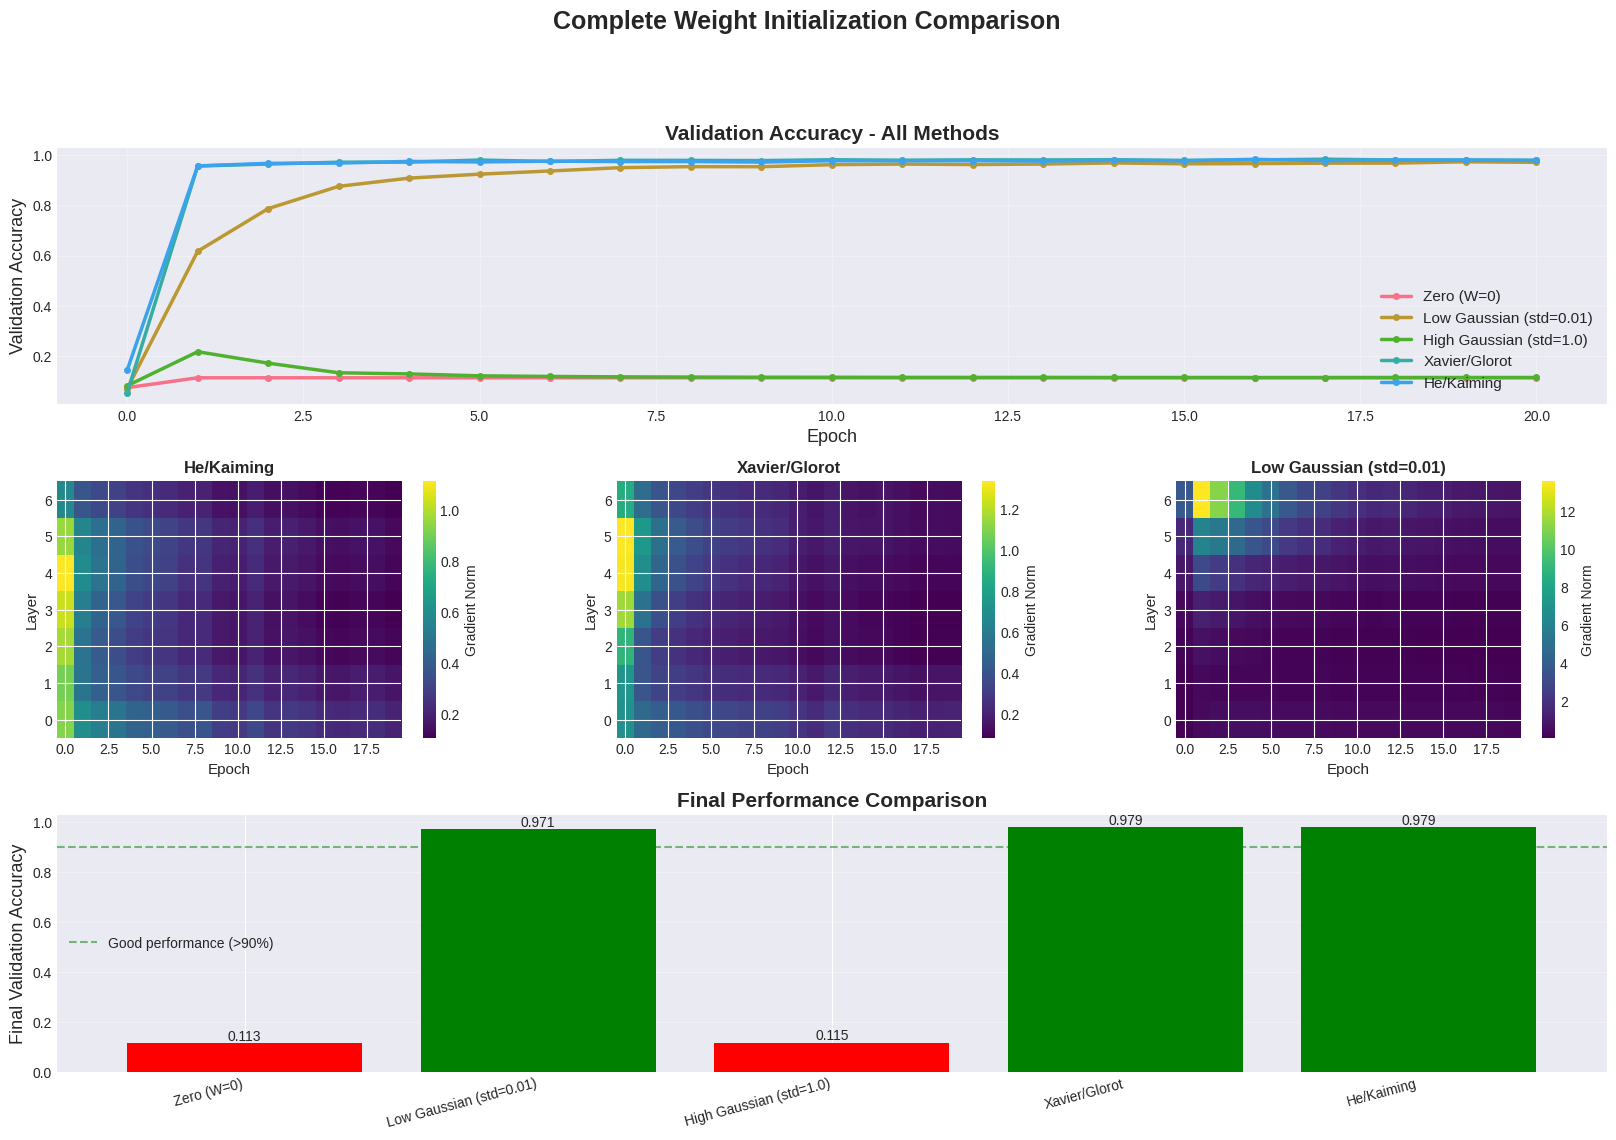


✓ Complete comparison visualization created!


In [13]:
# Create comprehensive comparison figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Validation Accuracy
ax1 = fig.add_subplot(gs[0, :])
for name, data in results.items():
    if len(data['val_accs']) > 0:
        ax1.plot(data['val_accs'], label=name, linewidth=2.5, marker='o', markersize=4)
ax1.set_xlabel('Epoch', fontsize=13)
ax1.set_ylabel('Validation Accuracy', fontsize=13)
ax1.set_title('Validation Accuracy - All Methods', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Gradient heatmaps for top 3 methods
top_methods = ['He/Kaiming', 'Xavier/Glorot', 'Low Gaussian (std=0.01)']
for idx, name in enumerate(top_methods):
    if name in results:
        ax = fig.add_subplot(gs[1, idx])
        data = results[name]
        
        grad_data = [data['gradient_history'][layer_idx] 
                    for layer_idx in range(len(data['gradient_history']))]
        
        if len(grad_data) > 0 and len(grad_data[0]) > 0:
            grad_array = np.array(grad_data)
            im = ax.imshow(grad_array, aspect='auto', cmap='viridis', 
                          interpolation='nearest', origin='lower')
            ax.set_xlabel('Epoch', fontsize=11)
            ax.set_ylabel('Layer', fontsize=11)
            ax.set_title(f'{name}', fontsize=12, fontweight='bold')
            plt.colorbar(im, ax=ax, label='Gradient Norm')

# 3. Final performance bars
ax_bar = fig.add_subplot(gs[2, :])
methods = list(results.keys())
final_accs = [results[name]['val_accs'][-1] if len(results[name]['val_accs']) > 0 else 0 
             for name in methods]

bars = ax_bar.bar(range(len(methods)), final_accs, 
                  color=['red' if acc < 0.5 else 'orange' if acc < 0.8 else 'green' 
                        for acc in final_accs])
ax_bar.set_xticks(range(len(methods)))
ax_bar.set_xticklabels(methods, rotation=15, ha='right')
ax_bar.set_ylabel('Final Validation Accuracy', fontsize=13)
ax_bar.set_title('Final Performance Comparison', fontsize=15, fontweight='bold')
ax_bar.grid(True, alpha=0.3, axis='y')
ax_bar.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Good performance (>90%)')
ax_bar.legend()

# Add values on bars
for bar, acc in zip(bars, final_accs):
    height = bar.get_height()
    ax_bar.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Complete Weight Initialization Comparison', 
            fontsize=18, fontweight='bold', y=0.995)
plt.savefig('complete_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Complete comparison visualization created!")

## Conclusion

This notebook demonstrates the critical importance of proper weight initialization in deep neural networks. 

**For your students, emphasize:**
- Always use appropriate initialization (He for ReLU, Xavier for tanh/sigmoid)
- Monitor gradient flow during training
- Deeper networks are more sensitive to initialization
- Modern frameworks (PyTorch, TensorFlow) use good defaults, but understanding why matters!

**Files generated:**
- `initialization_loss_accuracy.png` - Loss and accuracy curves
- `initialization_gradient_flow.png` - Gradient heatmaps
- `gradient_per_layer.png` - Layer-wise gradient analysis
- `complete_comparison.png` - Comprehensive comparison
- `gradient_anim_*.gif` - Animated gradient flow
- `weight_dist_*.png` - Weight distribution evolution